In [1]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

Import CSV

In [2]:
#load assesment file
TSLA = "resources/HistoricalData_TSLA.csv"
TSLA_df = pd.read_csv(TSLA)
TSLA_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/24/2021,$606.44,34558090,$581.6,$614.48,$573.65
1,05/21/2021,$580.88,26030600,$596.11,$596.68,$580
2,05/20/2021,$586.78,30821120,$575,$588.85,$571.07
3,05/19/2021,$563.46,39578400,$552.55,$566.21,$546.98
4,05/18/2021,$577.87,36830570,$568,$596.25,$563.38


CLEAN, RESHAPE AND CONVERT DATATYPE

In [5]:
TSLA_df['Date']= pd.to_datetime(TSLA_df['Date'])
TSLA_df['Close/Last'] = TSLA_df['Close/Last'].str.replace('$','')
TSLA_df['Open'] = TSLA_df['Open'].str.replace('$','')
TSLA_df['High'] = TSLA_df['High'].str.replace('$','')
TSLA_df['Low'] = TSLA_df['Low'].str.replace('$','')
TSLA_df = TSLA_df.apply( pd.to_numeric)

<ipython-input-5-d7e0cc37866b>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  TSLA_df['Close/Last'] = TSLA_df['Close/Last'].str.replace('$','')
<ipython-input-5-d7e0cc37866b>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  TSLA_df['Open'] = TSLA_df['Open'].str.replace('$','')
<ipython-input-5-d7e0cc37866b>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  TSLA_df['High'] = TSLA_df['High'].str.replace('$','')
<ipython-input-5-d7e0cc37866b>:5: FutureWarning: The default value of regex will change from True to False in a fut

FORMAT DATE COLUMN

In [6]:
TSLA_df['Date']= pd.to_datetime(TSLA_df['Date'])
TSLA_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2021-05-24,606.44,34558090,581.60,614.48,573.65
1,2021-05-21,580.88,26030600,596.11,596.68,580.00
2,2021-05-20,586.78,30821120,575.00,588.85,571.07
3,2021-05-19,563.46,39578400,552.55,566.21,546.98
4,2021-05-18,577.87,36830570,568.00,596.25,563.38


CREATE ADDITIONAL DATA

In [8]:
TSLA_df['Open_Close'] = (TSLA_df['Open'] - TSLA_df['Close/Last'])/TSLA_df['Open']
TSLA_df['High_Low'] = (TSLA_df['High'] - TSLA_df['Low'])/TSLA_df['Low']
TSLA_df['Increase_Decrease'] = np.where(TSLA_df['Volume'].shift(-1) > TSLA_df['Volume'],1,0)
TSLA_df['Buy_Sell_on_Open'] = np.where(TSLA_df['Open'].shift(-1) > TSLA_df['Open'],1,0)
TSLA_df['Buy_Sell'] = np.where(TSLA_df['Close/Last'].shift(-1) > TSLA_df['Close/Last'],1,0)
TSLA_df['Returns'] = TSLA_df['Close/Last'].pct_change()
TSLA_df = TSLA_df.dropna()
TSLA_df.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,580.88,26030600,596.110,596.68,580.00,0.025549,0.028759,1,0,1,-0.042148
2,2021-05-20,586.78,30821120,575.000,588.85,571.07,-0.020487,0.031135,1,0,0,0.010157
3,2021-05-19,563.46,39578400,552.550,566.21,546.98,-0.019745,0.035157,0,1,1,-0.039742
4,2021-05-18,577.87,36830570,568.000,596.25,563.38,-0.017377,0.058344,0,1,0,0.025574
5,2021-05-17,576.83,32247800,575.553,589.73,561.20,-0.002219,0.050837,1,1,1,-0.001800


SPLIT DATAFRAME

In [9]:
#setup datetime for first 4 years
start_date = "2016-05-24"
end_date = "2020-05-24"

after_start_date = TSLA_df["Date"] >= start_date
before_end_date = TSLA_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
TSLA_df_4 = TSLA_df.loc[between_two_dates]
TSLA_df_4.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
252,2020-05-22,163.376,49937375,164.4348,166.356,162.400,0.006439,0.024360,1,0,1,-0.002430
253,2020-05-21,165.520,61272900,163.2000,166.500,159.200,-0.014216,0.045854,0,1,0,0.013123
254,2020-05-20,163.112,36546355,164.1000,165.200,162.360,0.006021,0.017492,1,0,0,-0.014548
255,2020-05-19,161.602,48182610,163.0340,164.414,161.216,0.008783,0.019837,1,1,1,-0.009257
256,2020-05-18,162.726,58490500,165.5560,166.944,160.776,0.017094,0.038364,0,0,0,0.006955


SPLIT DATAFRAME

In [10]:
#setup datetime for last year
start_date = "2020-05-25"
end_date = "2021-05-24"

after_start_date = TSLA_df["Date"] >= start_date
before_end_date = TSLA_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
TSLA_df_ls = TSLA_df.loc[between_two_dates]
TSLA_df_ls.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,580.88,26030600,596.110,596.68,580.00,0.025549,0.028759,1,0,1,-0.042148
2,2021-05-20,586.78,30821120,575.000,588.85,571.07,-0.020487,0.031135,1,0,0,0.010157
3,2021-05-19,563.46,39578400,552.550,566.21,546.98,-0.019745,0.035157,0,1,1,-0.039742
4,2021-05-18,577.87,36830570,568.000,596.25,563.38,-0.017377,0.058344,0,1,0,0.025574
5,2021-05-17,576.83,32247800,575.553,589.73,561.20,-0.002219,0.050837,1,1,1,-0.001800


PLOT 1ST DF (4YEARS)

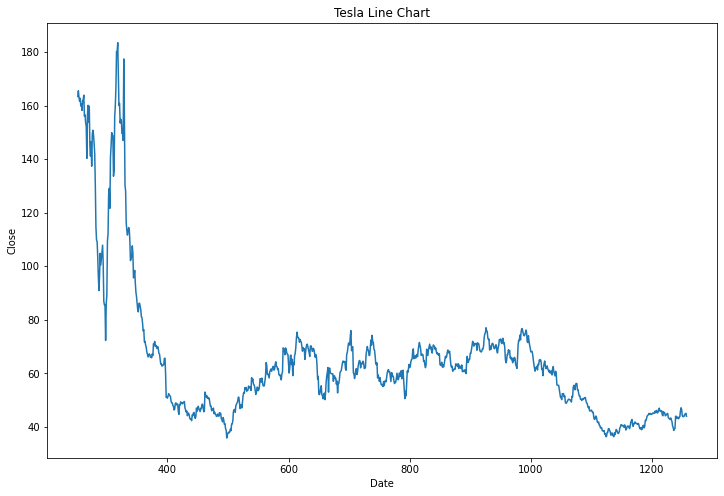

In [12]:
plt.figure(figsize=(12,8))
plt.plot(TSLA_df_4['Close/Last'])
plt.title("Tesla Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

PLOT SECOND DF (LAST YEAR)

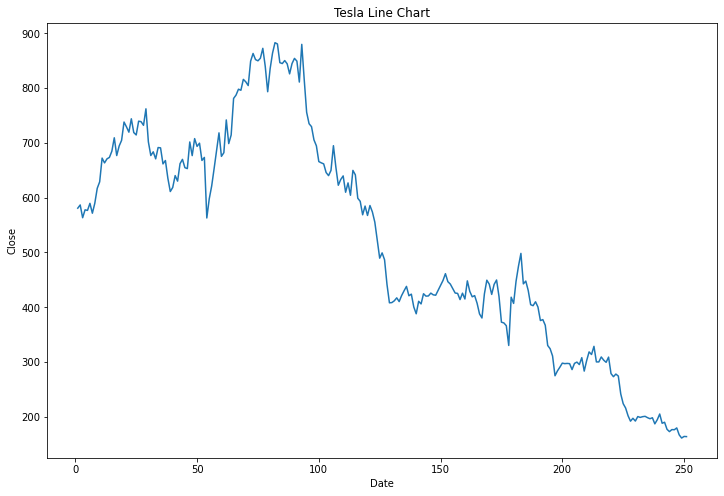

In [13]:
plt.figure(figsize=(12,8))
plt.plot(TSLA_df_ls['Close/Last'])
plt.title("Tesla Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

SHAPPING, FITTING, TRAINING, TESTING ML ON 1ST DF

In [14]:
TSLA_df_4.shape

(1006, 12)

In [15]:
X = np.array(TSLA_df_4['Open']).reshape(1006,-1)
Y = np.array(TSLA_df_4['Close/Last']).reshape(1006,-1)

In [16]:
lr = LinearRegression()

In [17]:
lr.fit(X, Y)

LinearRegression()

In [18]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [0.32366725]
coefficient count: 1


In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy:', lr.score(X, Y))

Accuracy: 0.9927719900839321


In [20]:
# Predicting the price
lr.predict(X)

array([[164.01615779],
       [162.78693206],
       [163.68286918],
       ...,
       [ 45.11853238],
       [ 44.22458623],
       [ 43.70892465]])

In [21]:
#daily Return
DA_RE = TSLA_df_4['Close/Last'].pct_change(1)
DA_RE.head()

252         NaN
253    0.013123
254   -0.014548
255   -0.009257
256    0.006955
Name: Close/Last, dtype: float64

Text(0.5, 1.0, '4 Years CLosing Price vs Predicted Closing Price')

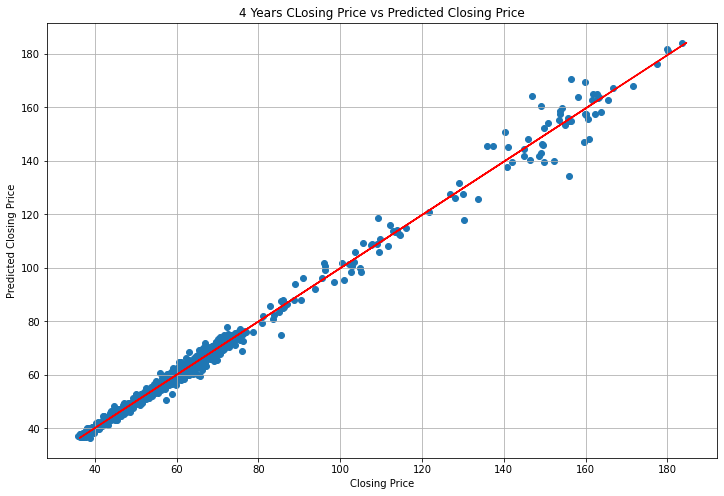

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(TSLA_df_4['Close/Last'], lr.predict(X))
plt.plot(X, lr.predict(X), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/TSLA_4y.jpg', dpi=40)
plt.grid()
plt.title('4 Years CLosing Price vs Predicted Closing Price')

In [23]:
TSLA_df_ls.shape

(251, 12)

In [24]:
X_ls = np.array(TSLA_df_ls['Open']).reshape(251,-1)
Y_ls = np.array(TSLA_df_ls['Close/Last']).reshape(251,-1)

In [25]:
lr.fit(X_ls, Y_ls)

LinearRegression()

In [26]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [3.38102435]
coefficient count: 1


In [27]:
print('Accuracy:', lr.score(X_ls, Y_ls))

Accuracy: 0.991127567383132


In [28]:
# Predicting the price
lr.predict(X_ls)

array([[595.74883469],
       [574.77135658],
       [552.46229056],
       [567.81530036],
       [575.32088502],
       [583.12856126],
       [601.14971548],
       [602.08878307],
       [598.85918554],
       [664.10699287],
       [665.00134295],
       [679.86742881],
       [680.16554551],
       [678.0588542 ],
       [702.762791  ],
       [666.7801059 ],
       [698.49972226],
       [695.41918307],
       [716.833899  ],
       [739.72926119],
       [718.66234807],
       [740.22612234],
       [703.72670164],
       [716.29728895],
       [718.4636036 ],
       [727.45679057],
       [741.81607805],
       [769.242814  ],
       [711.60691962],
       [684.77641706],
       [676.89619909],
       [676.50864738],
       [686.06825607],
       [689.34753972],
       [706.64824526],
       [687.42965565],
       [645.94174891],
       [601.35342855],
       [615.15623154],
       [641.22156791],
       [612.53280462],
       [667.09809704],
       [674.90875445],
       [683

Text(0.5, 1.0, '1 Year CLosing Price vs Predicted Closing Price')

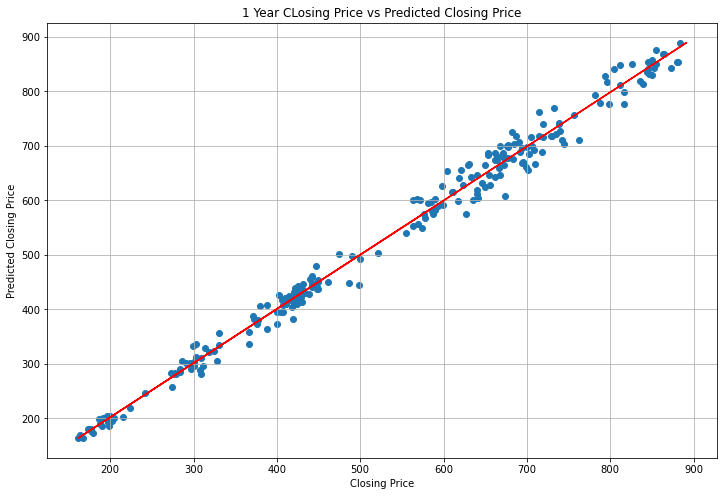

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(TSLA_df_ls['Close/Last'], lr.predict(X_ls))
plt.plot(X_ls, lr.predict(X_ls), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/TSLA_ls.jpg', dpi=40)
plt.grid()
plt.title('1 Year CLosing Price vs Predicted Closing Price')

In [30]:
TSLA_df.shape

(1257, 12)

In [31]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')

In [32]:

Xc = np.array(TSLA_df['Returns'], dtype = float) # Feature
Yc = np.array(TSLA_df['Close/Last'], dtype = float) # Target

In [33]:
model.fit(Xc, Yc, epochs=100)

Epoch 1/100
40/40 [==============================] - 1s 13ms/step - loss: 54153.5469
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 44316.6719
Epoch 3/100
40/40 [==============================] - 1s 13ms/step - loss: 42340.5000
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 41997.2930
Epoch 5/100
40/40 [==============================] - 1s 16ms/step - loss: 41915.8516
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 41878.8867
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 41883.4570
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 41880.2695
Epoch 9/100
40/40 [==============================] - 1s 16ms/step - loss: 41874.9023: 0s - loss: 4662
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 41874.6367
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 41894.2695
Epoch 12/100
40/40 [==============================] -

40/40 [==============================] - 0s 2ms/step - loss: 41871.8164
Epoch 97/100
40/40 [==============================] - 0s 2ms/step - loss: 41882.5625
Epoch 98/100
40/40 [==============================] - 0s 2ms/step - loss: 41886.2773
Epoch 99/100
40/40 [==============================] - 0s 2ms/step - loss: 41877.7617
Epoch 100/100
40/40 [==============================] - 0s 2ms/step - loss: 41872.8789


In [34]:
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(np.array(TSLA_df['Returns']).reshape(1257,-1))
X = np.array(normalized_X, dtype = float)
normalized_Y = scaler.fit_transform(np.array(TSLA_df['Close/Last']).reshape(1257,-1))
Y = np.array(normalized_Y, dtype = float)

In [35]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [36]:

print((model.predict([0])))

[[155.78949]]
